# mnist_autoencoder.py
Autoencoder class stolen from Tensorflow's official models repo:
 http://github.com/tensorflow/models


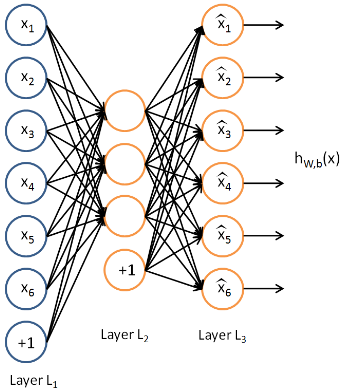

In [ ]:
import numpy as np
import random
import math
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [ ]:
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = low, maxval = high, dtype = tf.float32)

In [ ]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.sigmoid, optimizer = tf.train.AdamOptimizer(),
                 scale = 0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        network_weights = self._initialize_weights()
        self.weights = network_weights
        self.sparsity_level= np.repeat([0.05], self.n_hidden).astype(np.float32)
        self.sparse_reg = 0.0

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(self.x + scale * tf.random_normal((n_input,)),
                self.weights['w1']),
                self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0)) + self.sparse_reg \
                        * self.kl_divergence(self.sparsity_level, self.hidden)
            
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict = {self.x: X,
                                                                            self.scale: self.training_scale
                                                                            })
        return cost

    def kl_divergence(self, p, p_hat):
        return tf.reduce_mean(p * tf.log(p) - p * tf.log(p_hat) + (1 - p) * tf.log(1 - p) - (1 - p) * tf.log(1 - p_hat))

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X,
                                                     self.scale: self.training_scale
                                                     })

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X,
                                                       self.scale: self.training_scale
                                                       })

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X,
                                                               self.scale: self.training_scale
                                                               })

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [ ]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

In [ ]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

In [ ]:
X_train = mnist.train.images
X_test = mnist.test.images

In [ ]:
n_samples = int(mnist.train.num_examples)
training_epochs = 50
batch_size = 128
display_step = 1

In [ ]:
autoencoder = AdditiveGaussianNoiseAutoencoder(n_input = 784,
                                               n_hidden = 200,
                                               transfer_function = tf.nn.sigmoid,
                                               optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
                                               scale = 0.01)

In [ ]:
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        # Fit training using batch data
        cost = autoencoder.partial_fit(batch_xs)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost=", avg_cost)

In [ ]:
print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))

In [ ]:
# input weights
wts = autoencoder.getWeights()
dim = math.ceil(math.sqrt(autoencoder.n_hidden))
plt.figure(1, figsize=(dim, dim))

In [ ]:
for i in range(0,autoencoder.n_hidden):
    im = wts.flatten()[i::autoencoder.n_hidden].reshape((28,28))
    plt.subplot(dim, dim, i+1)
    #plt.title('Feature Weights ' + str(i))
    plt.imshow(im, cmap="gray", clim=(-1.0, 1.0))

In [ ]:
plt.show()

In [ ]:
predicted_imgs = autoencoder.reconstruct(X_test[:100])

In [ ]:
# plot the reconstructed images
plt.figure(1, figsize=(10, 10))
plt.title('Autoencoded Images')

In [ ]:
for i in range(0,100):
    im = predicted_imgs[i].reshape((28,28))
    plt.subplot(10, 10, i+1)
    plt.imshow(im, cmap="gray", clim=(0.0, 1.0))
plt.show()